In [1]:
import os
'''
os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=128"
'''

'\nos.environ["JAX_PLATFORMS"] = "cpu"\nos.environ["CUDA_VISIBLE_DEVICES"] = ""\nos.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=128"\n'

In [2]:
import jax
import jax.numpy as jnp
import SSjax
import NSjax
import NNjax
import h5py
import json
import time
import numpy
import pyccl
import scipy
from itertools import product
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.lines as mlines
import multiprocessing
import psutil
import threading

In [3]:
# Path
folder = '/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/SOMZCloud/'
cell_folder = os.path.join(folder, 'CELL/')
info_folder = os.path.join(folder, 'INFO/')
model_folder = os.path.join(folder, 'MODEL/')
synthesize_folder = os.path.join(folder, 'SYNTHESIZE/')

tag='Y1'
typ='FIDUCIAL'
label='DOUBLE'
name='SS'

os.makedirs(os.path.join(cell_folder, '{}/'.format(tag)), exist_ok = True)
os.makedirs(os.path.join(cell_folder, '{}/{}'.format(tag, name)), exist_ok = True)

In [4]:
# Load data
with h5py.File(os.path.join(synthesize_folder, '{}/{}_{}.hdf5'.format(tag, typ, label)), 'r') as file:
    data_source = file['source']['data'][...]
data_size, bin_source_size, z_size = data_source.shape

# Alignment
with open(os.path.join(info_folder, 'ALIGNMENT.json'), 'r') as file:
    alignment_info = json.load(file)

In [5]:
# Redshift
z1 = 0.0
z2 = 3.0
z_grid = numpy.linspace(z1, z2, z_size)

In [6]:
# Cosmology
with open(os.path.join(info_folder, 'COSMOLOGY.json'), 'r') as file:
    cosmology_info = json.load(file)

Omega_m = cosmology_info['OMEGA_M']

cosmology = pyccl.Cosmology(
    h=cosmology_info['H'],
    w0=cosmology_info['W0'],
    wa=cosmology_info['WA'],
    n_s=cosmology_info['NS'], 
    A_s=cosmology_info['AS'], 
    m_nu=cosmology_info['M_NU'],
    Neff=cosmology_info['N_EFF'],
    Omega_k=cosmology_info['OMEGA_K'], 
    Omega_b=cosmology_info['OMEGA_B'], 
    Omega_c=cosmology_info['OMEGA_CDM'],
    Omega_g=cosmology_info['OMEGA_GAMMA'], 
    mass_split = 'single', matter_power_spectrum = 'halofit', transfer_function = 'boltzmann_camb',
    extra_parameters = {'camb': {'kmax': 100, 'lmax': 5000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

    
pyccl.spline_params.N_K = z_size
pyccl.gsl_params.NZ_NORM_SPLINE_INTEGRATION = True

In [7]:
# Multipole
ell1 = 20
ell2 = 2000
ell_size = 20
ell_grid = numpy.geomspace(ell1, ell2, ell_size + 1)
ell_data = numpy.sqrt(ell_grid[+1:] * ell_grid[:-1])

A_GRID = numpy.array(1 / (1 + z_grid), dtype = 'double')

CHI_GRID = cosmology.comoving_radial_distance(a = A_GRID)
SOURCE_PHI_GRID = data_source * cosmology.h_over_h0(a = 1 / (1 + z_grid)) * cosmology_info['H'] * 100000 / scipy.constants.c

CHI_MESH, ELL_MESH = numpy.meshgrid(CHI_GRID, ell_grid)
SCALE_GRID = numpy.nan_to_num(numpy.divide(ELL_MESH + 1/2, CHI_MESH, out = numpy.zeros((ell_size + 1, z_size)) + numpy.inf, where = CHI_MESH > 0))
POWER_GRID = numpy.zeros((ell_size + 1, z_size))
for GRID_INDEX in range(z_size):

    POWER_GRID[:,GRID_INDEX] = cosmology.nonlin_matter_power(k = SCALE_GRID[:,GRID_INDEX], a = A_GRID[GRID_INDEX])

AMPLITUDE = 9 / 4 * Omega_m**2 * (cosmology_info['H'] * 100000 / scipy.constants.c)**4 * (1 + 3 / (2 * ell_grid + 1)) * (1 + 1 / (2 * ell_grid + 1)) * (1 - 1 / (2 * ell_grid + 1)) * (1 - 3 / (2 * ell_grid + 1))
AMPLITUDE_IS = 3 / 2 * Omega_m * (cosmology_info['H'] * 100000 / scipy.constants.c)**2 * numpy.sqrt((1 + 3 / (2 * ell_grid + 1)) * (1 + 1 / (2 * ell_grid + 1)) * (1 - 1 / (2 * ell_grid + 1)) * (1 - 3 / (2 * ell_grid + 1)))
AMPLITUDE_II = 1

In [8]:
#Angular power Spectra(CCL)
Number_of_round=500
C_CCL = numpy.zeros((Number_of_round, bin_source_size, bin_source_size, ell_size+1))
    
l_correct=numpy.sqrt((1 + 3 / (2 * ell_grid + 1)) * (1 + 1 / (2 * ell_grid + 1)) * (1 - 1 / (2 * ell_grid + 1)) * (1 - 3 / (2 * ell_grid + 1)))
A = numpy.asarray(alignment_info['A'])
POWER_GRID_IS = POWER_GRID * A
POWER_GRID_II = POWER_GRID * A * A
T_pyccl=numpy.zeros(Number_of_round)
for (r, i, j) in product(range(Number_of_round), range(bin_source_size), range(bin_source_size)):
    T0 = time.time()
    tracer1 = pyccl.tracers.WeakLensingTracer(cosmo=cosmology, dndz=[z_grid, data_source[r, i, :]], has_shear=True, ia_bias=[z_grid, alignment_info['A']], use_A_ia=False, n_samples=z_size)
    tracer2 = pyccl.tracers.WeakLensingTracer(cosmo=cosmology, dndz=[z_grid, data_source[r, j, :]], has_shear=True, ia_bias=[z_grid, alignment_info['A']], use_A_ia=False, n_samples=z_size)
    C_CCL[r, i, j,:] = pyccl.cells.angular_cl(cosmo=cosmology, tracer1=tracer1, tracer2=tracer2, ell=ell_grid, p_of_k_a='delta_matter:delta_matter', l_limber=-1, limber_max_error=0.01, limber_integration_method='qag_quad', non_limber_integration_method='FKEM', fkem_chi_min=0, fkem_Nchi=z_size, p_of_k_a_lin='delta_matter:delta_matter', return_meta=False)
    T1 = time.time()
    T_pyccl[r]=T_pyccl[r]+T1-T0
    
print(T_pyccl)

[0.09732604 0.11856604 0.0716629  0.07950449 0.07127261 0.10289502
 0.07480597 0.07750297 0.07673955 0.07479739 0.0704     0.07426739
 0.06869674 0.07411146 0.07096767 0.0957799  0.07528734 0.0737505
 0.07066751 0.1077373  0.06572986 0.08200622 0.06906486 0.06891966
 0.06378269 0.06986737 0.06755638 0.07716894 0.07635045 0.07710099
 0.07482696 0.06511331 0.10246968 0.06067538 0.0617733  0.06272316
 0.06084633 0.06038952 0.06573248 0.06196642 0.06144667 0.06629467
 0.0673306  0.06564999 0.06344199 0.06238723 0.06331992 0.07481003
 0.06322217 0.06211853 0.06317806 0.06438303 0.06599402 0.0706172
 0.06374741 0.06483531 0.06297326 0.06862402 0.06563067 0.07486153
 0.06728315 0.07280421 0.0629313  0.06098294 0.0706439  0.06025648
 0.0627284  0.05973411 0.06330991 0.07481408 0.06303859 0.06039667
 0.05843472 0.05815768 0.05917025 0.0622561  0.06111574 0.05960941
 0.08575392 0.05880427 0.05884767 0.07900548 0.06534648 0.05660462
 0.0587678  0.056602   0.05589771 0.07820129 0.07526565 0.062559

In [9]:
#Angular power Spectra(TensorCloud)
SOURCE_PHI_GRID_j=SOURCE_PHI_GRID[:Number_of_round]

POWER_A   = POWER_GRID * A
POWER_A2  = POWER_GRID * (A * A)

def _one_round(phi1,phi2):
    
    SS = SSjax.function(AMPLITUDE,  phi1, phi2, CHI_GRID, POWER_GRID,  z_grid)              
    II = (l_correct * l_correct) * NNjax.function(AMPLITUDE_II, phi1, phi2, CHI_GRID, POWER_A2 , z_grid)
    IS =  l_correct * NSjax.function(AMPLITUDE_IS, phi1, phi2, CHI_GRID, POWER_A,  z_grid)
    SI = jnp.swapaxes(IS, 0, 1)  

    return SS + IS + SI + II  

batched_fn = jax.jit(jax.vmap(_one_round, in_axes=(0,0)))   

SOURCE_PHI_GRID_j = jnp.asarray(SOURCE_PHI_GRID_j) 

t0 = time.time()
C_DEV = batched_fn(SOURCE_PHI_GRID_j,SOURCE_PHI_GRID_j)   
C_DEV.block_until_ready()               
t1 = time.time()
T_total = t1 - t0

C_DATA = numpy.asarray(C_DEV)

print(T_total/Number_of_round)

0.023445537090301515


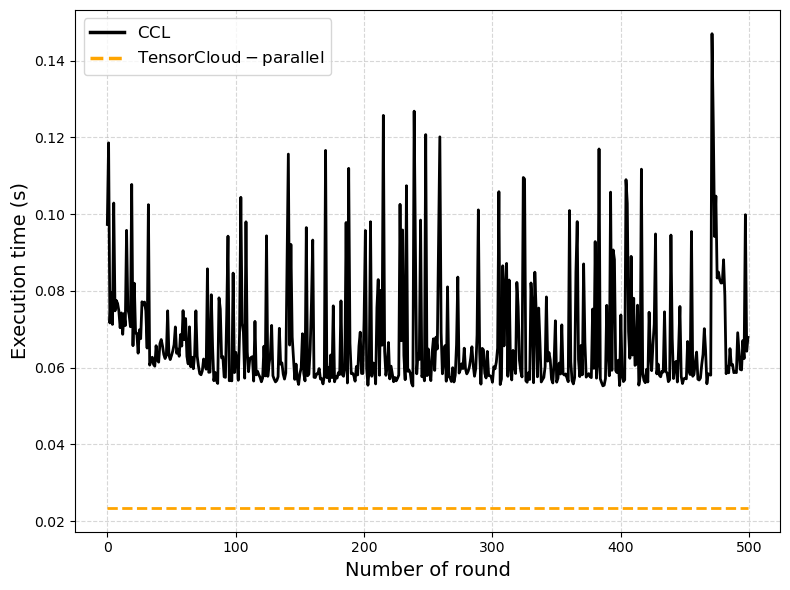

In [10]:
pyplot.figure(figsize=(8,6))

pyplot.plot(numpy.arange(Number_of_round), T_pyccl, color='black', linestyle='-', linewidth=2.0)
pyplot.hlines(y=T_total/Number_of_round, xmin=0, xmax=Number_of_round-1, color='orange', linestyle='--', linewidth=2.0)


legend_handles = [
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5, label=r'$\mathrm{CCL}$'),
    mlines.Line2D([], [], color='orange', linestyle='--', linewidth=2.5, label=r'$\mathrm{TensorCloud-parallel}$'),
]
pyplot.legend(handles=legend_handles, fontsize=12)

pyplot.xlabel("Number of round", fontsize=14)
pyplot.ylabel("Execution time (s)", fontsize=14)

pyplot.grid(True, linestyle='--', alpha=0.5)
pyplot.tight_layout()
pyplot.show()

In [11]:
#Calculate the difference
C_DATA_mean=numpy.mean(C_DATA, axis=0)
C_CCL_mean=numpy.mean(C_CCL, axis=0)
C_RATIO = numpy.divide(C_DATA_mean, C_CCL_mean, out = numpy.ones(C_CCL_mean.shape), where = C_CCL_mean > 0)

In [12]:
# Bin
with h5py.File(os.path.join(model_folder, '{}/TARGET/DATA0.hdf5'.format(tag)), 'r') as file:
    bin_lens = file['bin_lens'][...]
    bin_source = file['bin_source'][...]

bin_lens_size = len(bin_lens) - 1
bin_source_size = len(bin_source) - 1

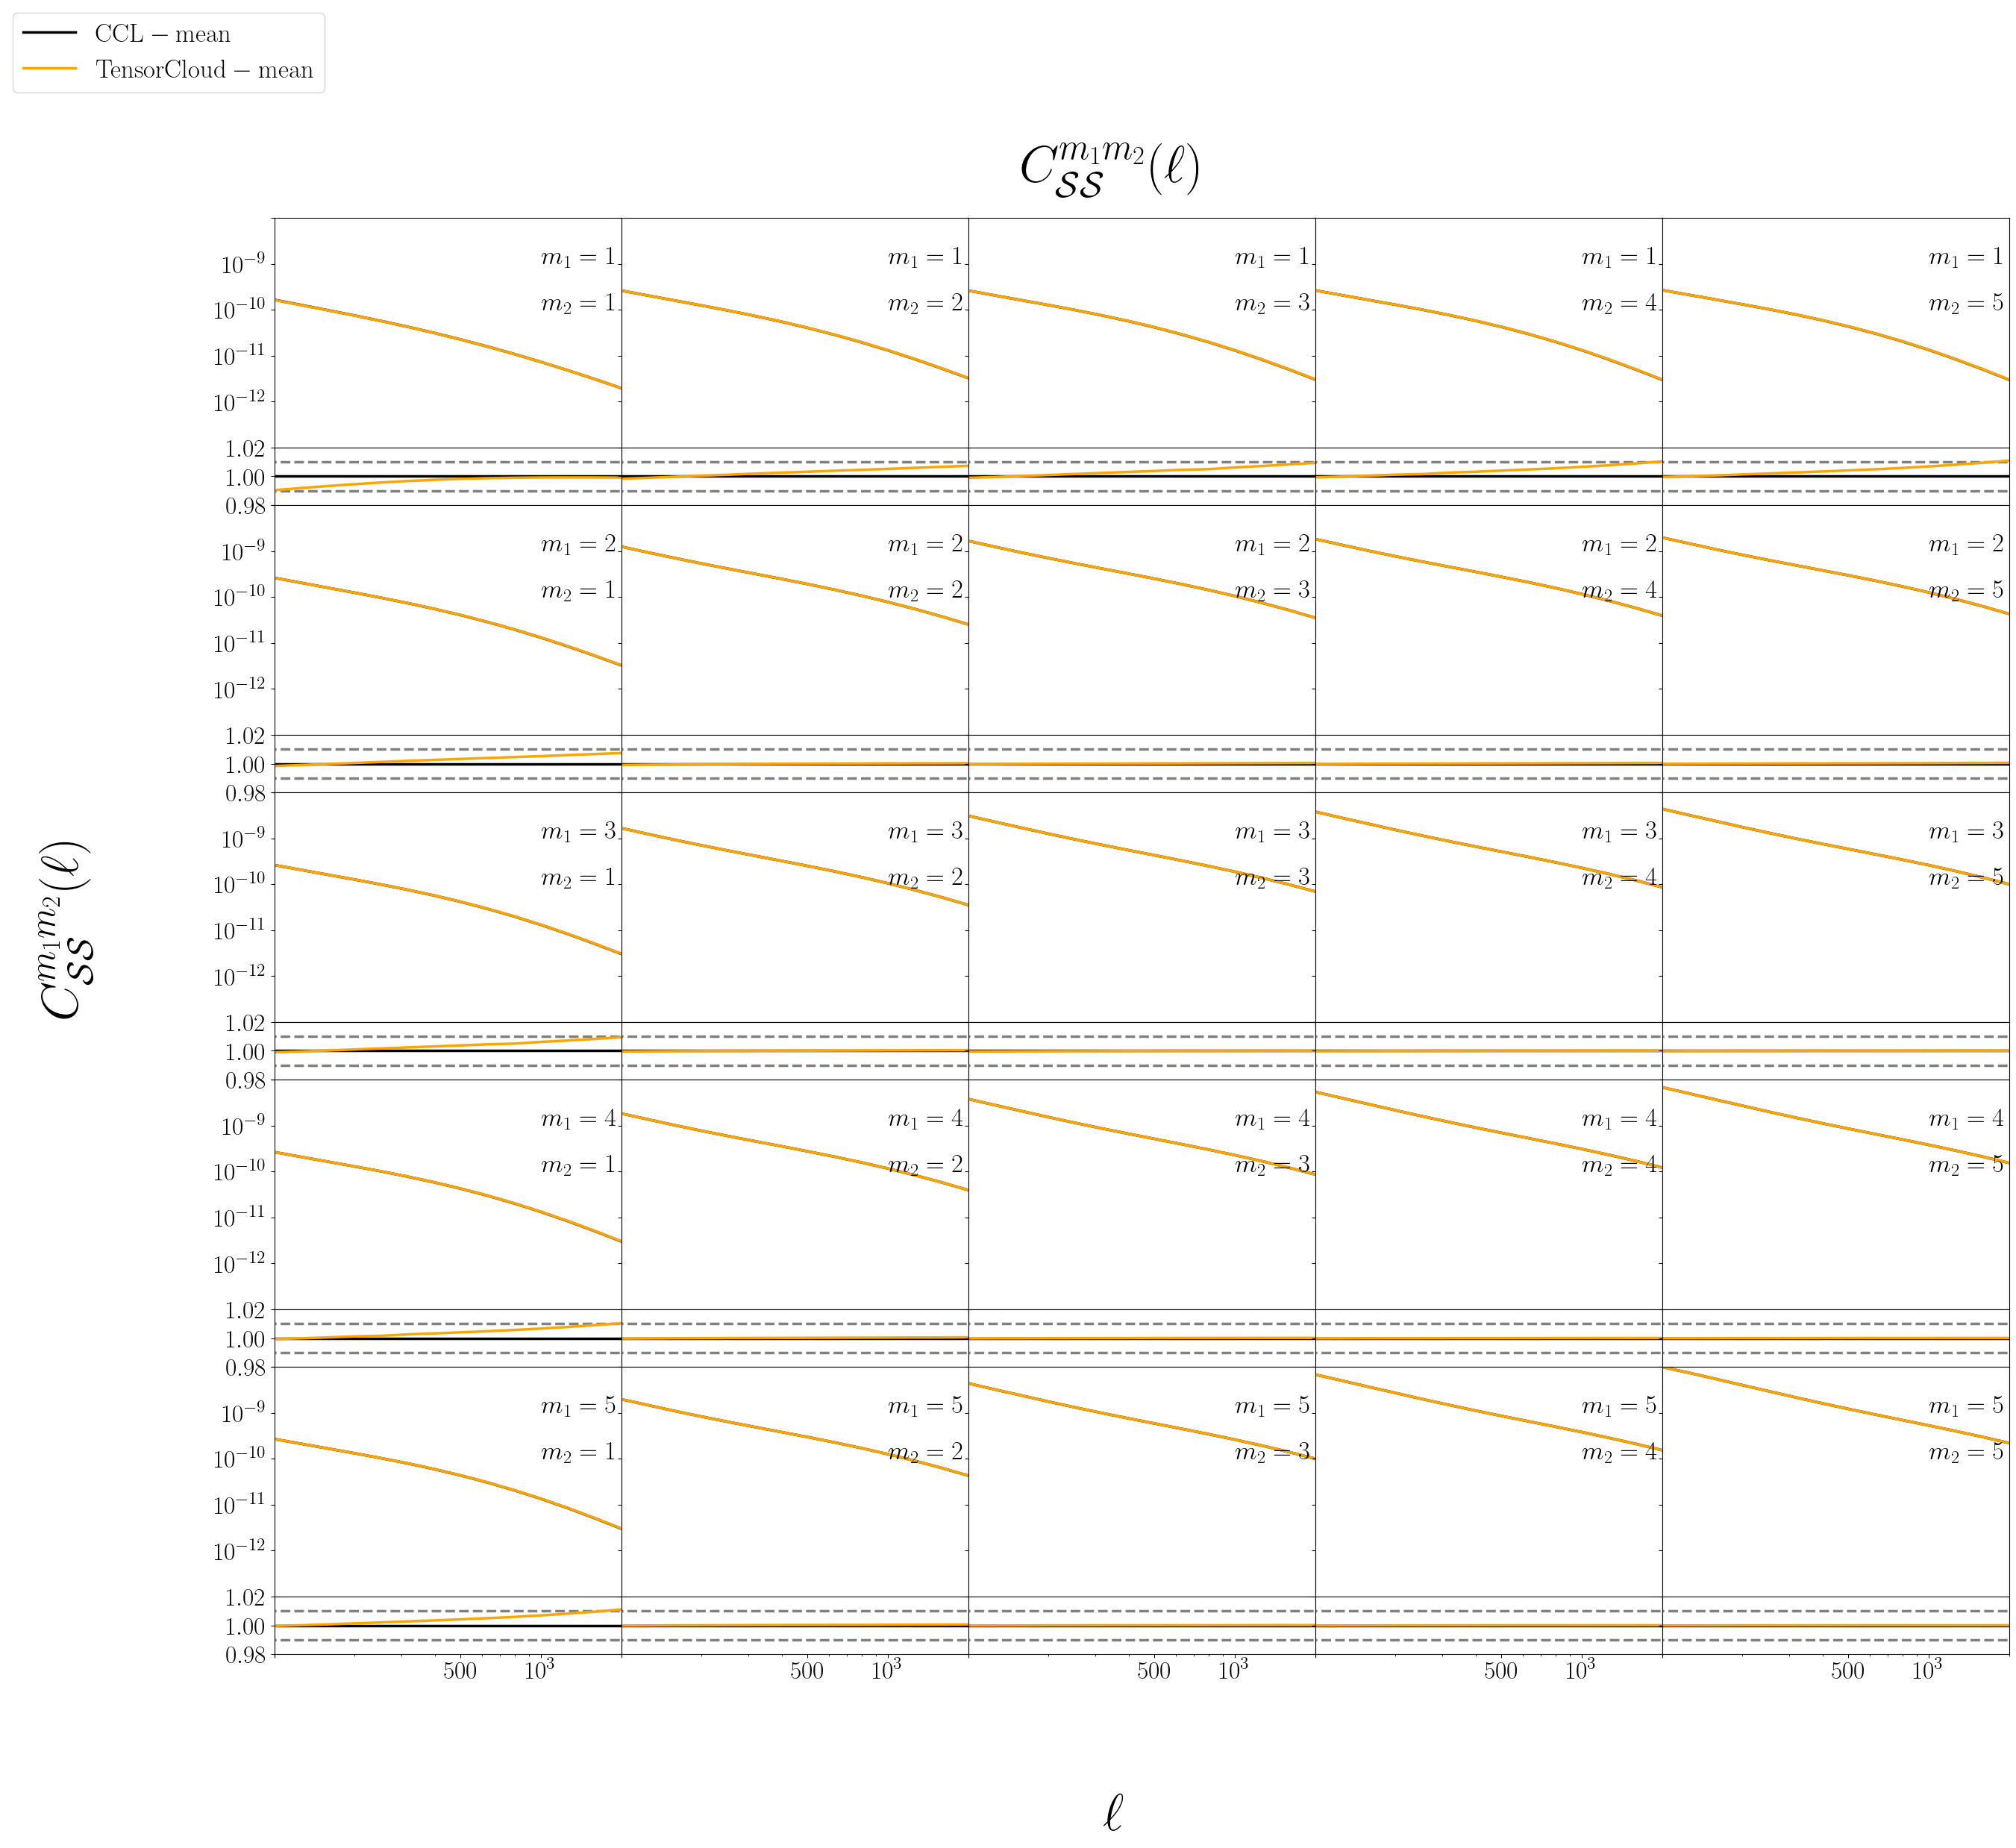

In [13]:
#Compare different bins
pyplot.rcParams['font.size'] = 24
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (bin_source_size * 6, bin_source_size * 5))
GRIDSPEC = GridSpec(5 * bin_source_size, 6 * bin_source_size, figure = FIGURE, wspace = 0.0, hspace = 0.0)

for (BIN_INDEX1, BIN_INDEX2) in product(range(bin_source_size), range(bin_source_size)):
    
    PLOT = FIGURE.add_subplot(GRIDSPEC[5 * BIN_INDEX1: 5 * BIN_INDEX1 + 4, 6 * BIN_INDEX2: 6 * BIN_INDEX2 + 6])

    PLOT.plot(ell_grid, C_CCL_mean[BIN_INDEX1, BIN_INDEX2,:], color = 'black', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{CCL-mean}$')
  
    PLOT.plot(ell_grid, C_DATA_mean[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{TensorCloud-mean}$')

    PLOT.text(x = 10**3, y = 10**-9, s = r'$m_1= {:.0f}$'.format(BIN_INDEX1 + 1), fontsize = 25)

    PLOT.text(x = 10**3, y = 10**-10, s = r'$m_2 = {:.0f}$'.format(BIN_INDEX2 + 1), fontsize = 25)

    PLOT.set_yscale('log')
    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 2000)

    PLOT.set_ylim(10**-13, 10**-8)
    PLOT.yaxis.set_major_locator(FixedLocator([10**-8,10**-9,10**-10, 10**-11, 10**-12]))
    PLOT.yaxis.set_major_formatter(FixedFormatter([r'${10}^{-8}$',r'${10}^{-9}$', r'${10}^{-10}$', r'${10}^{-11}$', r'${10}^{-12}$']))
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
    
    PLOT.set_xticklabels([])
    PLOT.get_yticklabels()[0].set_visible([])

    PLOT = FIGURE.add_subplot(GRIDSPEC[BIN_INDEX1 * 5 + 4: BIN_INDEX1 * 5 + 5, BIN_INDEX2 * 6: BIN_INDEX2 * 6 + 6])

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1), color = 'black', linestyle = '-', linewidth = 2.5)

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)
    
    PLOT.plot(ell_grid, C_RATIO[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5)

    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 2000)
    PLOT.set_ylim(0.98, 1.02)
    PLOT.xaxis.set_major_locator(FixedLocator([100, 500, 1000]))
    PLOT.xaxis.set_major_formatter(FixedFormatter([r'$100$', r'$500$', r'${10}^3$']))

    if BIN_INDEX1 < bin_source_size - 1: PLOT.set_xticklabels([])
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
    PLOT.get_xticklabels()[0].set_visible([])
legend_handles = [
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5, label=r'$\mathrm{CCL-mean}$'),
    mlines.Line2D([], [], color='orange', linestyle='-', linewidth=2.5, label=r'$\mathrm{TensorCloud-mean}$')
]

FIGURE.legend(handles=legend_handles, loc='upper left', fontsize=25)
FIGURE.suptitle(r'$C^{m_1 m_2}_\mathcal{SS} (\ell)$', fontsize=50, y=0.92)
FIGURE.supxlabel(r'$\ell$', fontsize = 50)
FIGURE.supylabel(r'$C^{m_1 m_2}_\mathcal{SS} (\ell)$', fontsize = 50)

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.savefig('CSS-Y1.png')
FIGURE.show()